In [1]:
import numpy as onp
import jax.numpy as np
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax import config
config.update("jax_enable_x64", True)


from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util
from jax_md.util import f32

from collections import namedtuple

vectorize = np.vectorize

# normalize = lambda v: v / np.linalg.norm(v, axis=1, keepdims=True)

def normalize(v, v_lim=0):
    v_norm = np.linalg.norm(v, axis=1, keepdims=True)
    return np.where(v_norm > v_lim, v/v_norm, v)


from functools import partial
from simulator.utils import angle_correct, normal, align_tot
from simulator.render import render
from simulator.utils import ttc_potential_tot, time_to_collide, ttc_tot, ttc_potential_fn, ttc_force_tot, wall_energy, normalize_cap, wall_energy_tot
import matplotlib.pyplot as plt

class PedestrianState(namedtuple("PedestrianState", ['position', 'velocity', 'radius', 'goal_velocity'])):
    # 'group_velocity'
    def orientation(self):
        """Returns the orientation angle of all pedestrians"""
        return angle_correct(np.atan2(self.position[:, 0], self.position[:, 1]))

In [2]:
displacement, shift = space.free()

dpos = np.array([5, 0])
rela_v = np.array([4.01, 2.99]) / 5
print(time_to_collide(dpos, rela_v, np.zeros((2, ), dtype=f32), 1.5))

3.7477961645620224


In [3]:
np.sqrt(-1)

Array(nan, dtype=float64, weak_type=True)

In [4]:
pos = np.array([[0.0, 0.0],
                [3.0, 0.0]])

velocity = np.array([[1.0, 0.0],
                     [0.0, 0.0]])

print(ttc_tot(pos, velocity, 1, displacement))

print(ttc_potential_fn(1.5, np.reshape(ttc_tot(pos, velocity, 1, displacement), shape=(4, )), 3.0))

[[99.  1.]
 [ 1. 99.]]
[7.13022061e-19 1.07479697e+00 1.07479697e+00 7.13022061e-19]


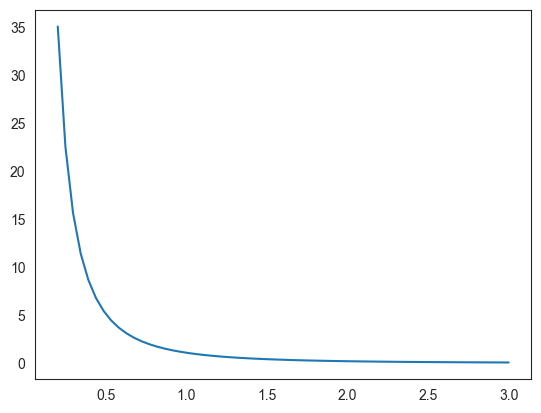

In [15]:
dt = np.linspace(0.2, 3., 60)
Es = ttc_potential_fn(1.5, dt, 3.0)

plt.plot(dt, Es)

In [11]:
np.arange(0, 10)


Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [3]:
pos = np.array([[0.0, 0.0],
                [3.0, 0.0]])

velocity = np.array([[1.0, 0.0],
                     [0.0, 0.0]])

print(ttc_force_tot(pos, velocity, 1.0, displacement))
print(normalize_cap(ttc_force_tot(pos, velocity, 1.0, displacement), 5))

print(np.sum(ttc_force_tot(pos, velocity, 1.0, displacement), axis=1))
print(np.sum(normalize_cap(ttc_force_tot(pos, velocity, 1.0, displacement)), axis=1))

# print(normalize(ttc_force_tot(pos, velocity, 1.0, displacement)))
# print(np.sum(ttc_force_tot(pos, velocity, 1.0, displacement), axis=1))
# print(np.sum(normalize(ttc_force_tot(pos, velocity, 1.0, displacement)), axis=1))

[[[ 0.          0.        ]
  [-5.01571917 -0.        ]]

 [[ 5.01571917 -0.        ]
  [ 0.          0.        ]]]
[[[ 0.  0.]
  [-1. -0.]]

 [[ 1. -0.]
  [ 0.  0.]]]
[[-5.01571917  0.        ]
 [ 5.01571917  0.        ]]
[[-1.  0.]
 [ 1.  0.]]


In [5]:
# @jit
# def wall_energy(pos, wall):
#    wall_start, wall_end = wall
#    wall_tangent = wall_end - wall_start
#    wall_normal = test_normalize_cap(np.array([-wall_tangent[1], wall_tangent[0]]))

#    return 1/np.dot(pos, wall_normal)

print(wall_energy(np.array([[0.0, 5.0], [3.0, 10.0]]), np.array([[0, 0], [10, 0]])))
print(quantity.force(wall_energy)(np.array([[0.0, 5.0], [3.0, 10.0]]), np.array([[0, 0], [10, 0]])))

0.30000000000000004
[[0.   0.04]
 [0.   0.01]]


In [12]:
def wall_dist(pos, start, end):
    wall_len = np.dot(end - start, end - start)
    # t = max(0, min(1, np.dot(pos - start, end - start) / wall_len))
    t = np.max(np.array([0, np.min(np.array([1, np.dot(pos - start, end - start) / wall_len]), axis = 0)]), axis = 0)
    proj = start + t * (end - start)
    return displacement(pos, proj)

print(wall_dist(np.array([0.0, 3.0]), np.array([4.0, 0.0]), np.array([10.0, 0.0])))

[-4.  3.]


In [16]:
class StraightWall(namedtuple('StraightWall', ['start', 'end'])):
    pass

pos = np.array([[1.0, 0.0],
                [3.0, 0.0]])

wall1 = StraightWall(np.array([4.0, 0.0]), np.array([10.0, 0.0]))
wall2 = StraightWall(np.array([0.0, 1.0]), np.array([0.0, 9.0]))
walls = np.array([wall1, wall2])

def true_wall_energy_tot(poss, walls, displacement):
    return vmap(wall_energy_tot, (None, 0, None))(poss, walls, displacement)

true_wall_energy_tot(pos, walls, displacement)


AttributeError: BatchTracer has no attribute start